# Online Toxicity Prediction Model

<img src="https://imageio.forbes.com/specials-images/dam/imageserve/865651234/0x0.jpg?format=jpg&width=1200" width="1200" height="900" align="center"/>

### Importing Dependencies

In [1]:
#EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Implementation Libraries
import string
from collections import Counter

#NLTK Libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#ML Models and Evaluation Metrics
from sklearn.model_selection import train_test_split
!pip install scikit-multilearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.4 MB/s eta 0:00:00


### Data Collection and Analysis

In [2]:
url='https://docs.google.com/spreadsheets/d/1M-weyL03bKiOKgEeslEFhFci4E1hanKb/edit?usp=sharing&ouid=100549591817912324214&rtpof=true&sd=true'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_excel(url)

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


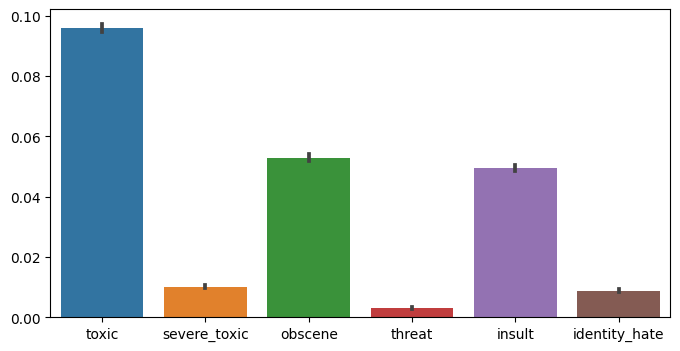

In [3]:
#Distribution of Toxicity Classes

plt.figure(figsize=(8,4))
sns.barplot(data[2:])
plt.show()

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Text Preprocessing

In [5]:
data = data.dropna()

In [6]:
data['comment_text'] = data['comment_text'].astype(str)
data['comment_text'] = data['comment_text'].str.lower()
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [8]:
punctuations = string.punctuation
def remove_punct(comment):
    return comment.translate(str.maketrans('', '', punctuations))

In [9]:
#Removing Punctuations

data['comment_text'] =data['comment_text'].apply(lambda comment: remove_punct(comment))
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,\nmore\ni cant make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


### Stopwords Removal

In [10]:
stopwrds = stopwords.words('english')
data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwrds)]))

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


### Frequent Words Removal

In [11]:
cnt = Counter()
for text in data['comment_text'].values:
    for word in text.split():
        cnt[word] += 1

In [12]:
cnt.most_common(20)

[('article', 55369),
 ('page', 45580),
 ('wikipedia', 35514),
 ('talk', 30482),
 ('please', 29589),
 ('would', 29207),
 ('one', 28033),
 ('like', 27695),
 ('dont', 25732),
 ('see', 21475),
 ('also', 20534),
 ('think', 20032),
 ('im', 19256),
 ('know', 18983),
 ('people', 17672),
 ('edit', 17573),
 ('articles', 17490),
 ('use', 16309),
 ('may', 15545),
 ('time', 15375)]

In [13]:
#Removing the top 20 most frequent words

FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data['comment_text'] = data['comment_text'].apply(lambda text: remove_freqwords(text))

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying war guy constantly remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember thats,0,0,0,0,0,0


### Lemmatization

In [14]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data['comment_text'] = data['comment_text'].apply(lambda text: lemmatize_words(text))

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww match background colour seemingly stuck t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying war guy constantly remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestion improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember thats,0,0,0,0,0,0


### Preparing Training and Testing Data

In [15]:
test = data.sample(frac = 0.2)
train = data.drop(test.index)

In [16]:
X_train = train['comment_text']
y_train = train[train.columns[2:]]

X_test = test['comment_text']
y_test = test[test.columns[2:]]

In [17]:
test.shape, train.shape

((31890, 8), (127559, 8))

# Feature Extraction using TF-IDF

In [18]:
X = data['comment_text']

vectorizar = TfidfVectorizer()
vectorizar.fit(X)

TfidfVectorizer()

In [19]:
X_train_tfidf = vectorizar.transform(X_train)
X_test_tfidf = vectorizar.transform(X_test)

In [20]:
X_test_tfidf

<31890x242084 sparse matrix of type '<class 'numpy.float64'>'
	with 814457 stored elements in Compressed Sparse Row format>

# Model Training


In [21]:
classifier = LogisticRegression(max_iter = 1000)

Label: toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28763
           1       0.91      0.57      0.70      3127

    accuracy                           0.95     31890
   macro avg       0.93      0.78      0.84     31890
weighted avg       0.95      0.95      0.95     31890

Confusion Matrix of Label : toxic


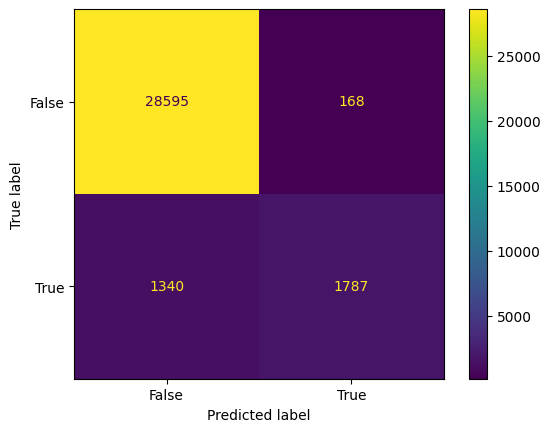

Label: severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     31563
           1       0.52      0.23      0.32       327

    accuracy                           0.99     31890
   macro avg       0.76      0.61      0.66     31890
weighted avg       0.99      0.99      0.99     31890

Confusion Matrix of Label : severe_toxic


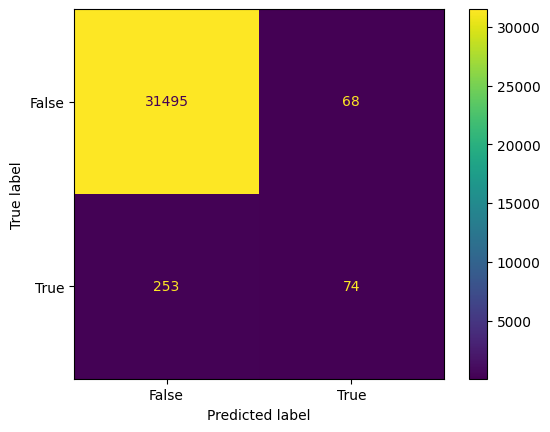

Label: obscene
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30164
           1       0.92      0.60      0.73      1726

    accuracy                           0.98     31890
   macro avg       0.95      0.80      0.86     31890
weighted avg       0.97      0.98      0.97     31890

Confusion Matrix of Label : obscene


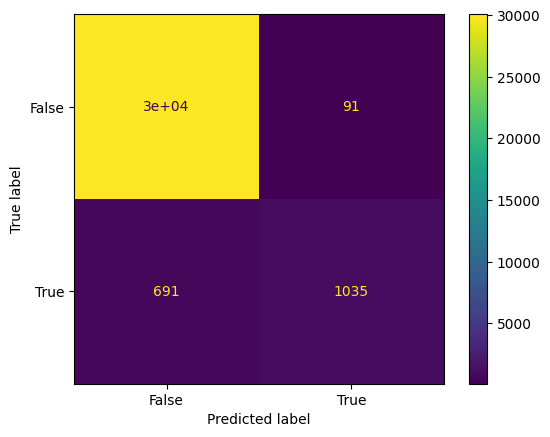

Label: threat
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31792
           1       0.83      0.10      0.18        98

    accuracy                           1.00     31890
   macro avg       0.92      0.55      0.59     31890
weighted avg       1.00      1.00      1.00     31890

Confusion Matrix of Label : threat


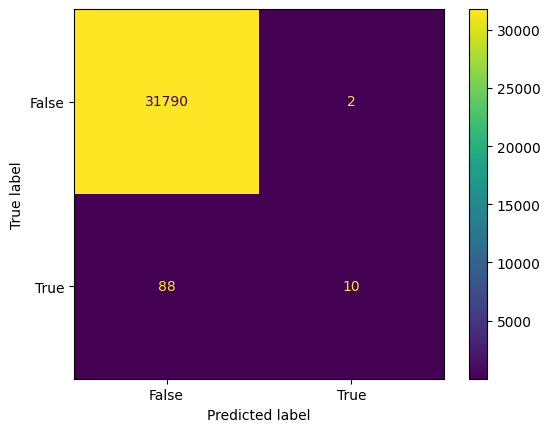

Label: insult
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     30286
           1       0.83      0.47      0.60      1604

    accuracy                           0.97     31890
   macro avg       0.90      0.73      0.79     31890
weighted avg       0.97      0.97      0.96     31890

Confusion Matrix of Label : insult


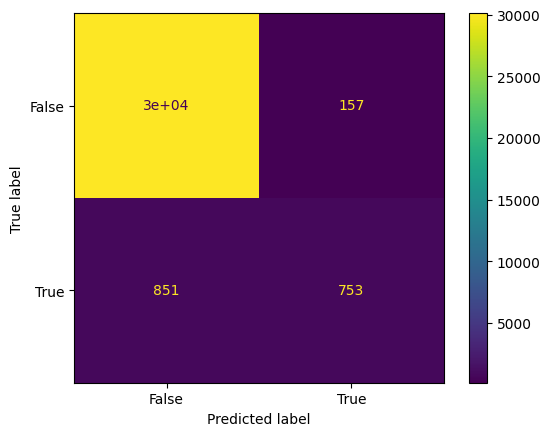

Label: identity_hate
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31614
           1       0.60      0.14      0.23       276

    accuracy                           0.99     31890
   macro avg       0.80      0.57      0.61     31890
weighted avg       0.99      0.99      0.99     31890

Confusion Matrix of Label : identity_hate


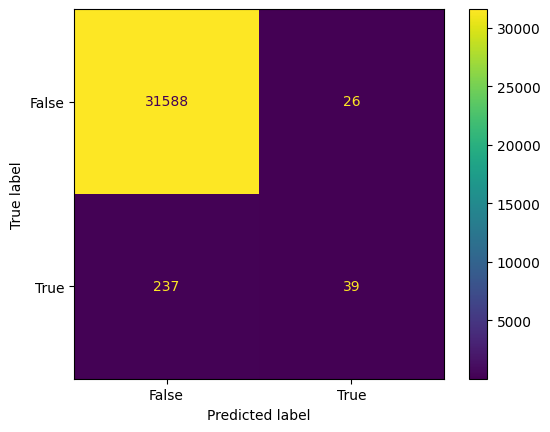

In [23]:
itr = 0
for label in labels:
    classifier.fit(X_train_tfidf, y_train.iloc[:, itr])
    predictions = classifier.predict(X_test_tfidf)
    print(f"Label: {label}")
    print(classification_report(y_test.iloc[:, itr], predictions))
    print(f'Confusion Matrix of Label : {label}')
    confusion_matrix = metrics.confusion_matrix(y_test.iloc[:, itr], predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    itr += 1